Packages

In [48]:
import numpy as np
import time
import matplotlib.pyplot as plt
import bisect
import math
import bisect

from scipy.stats import beta
from mpl_toolkits.mplot3d import Axes3D

Decorators

In [146]:
# test performance of a function
def timer(f):
    def countTime(*args, **kwargs):
        print("Start timing...")
        s = time.time()
        res = f(*args, **kwargs)
        e = time.time()
        print("End timing.")
        print("Processed in %f seconds." %(e-s))
        return res
    return countTime

In [40]:
# Convert a scalar function to a vector function
def vecfunc(f):
    return np.frompyfunc(f,1,1)

Functions

In [134]:
# find the position of each element in nx when put into mx
def vecBisect(mx: np.array, nx: np.array) -> np.array:
    
    @vecfunc
    def bis(x) -> int:
        return max(1,bisect.bisect_left(mx,x))
    
    return bis(nx)

# input: scatter monotonously increasing function my = f(mx), lattice nx
# output: scatter function ny = f(nx) using interpolation method
def regularizeFunction(mx, my, nx) -> np.array:
    pos = vecBisect(mx,nx).astype(int)
    mx, my = np.append(mx,1), np.append(my,1)
    ny = (my[pos]-my[pos-1])*(nx-mx[pos-1])/(mx[pos]-mx[pos-1])+my[pos]
    return ny

In [4]:
# Monte Carlo simulation
def monteCarlo(steps: int, weights: np.array, mult: np.array):
    # weights = eigenvalue vector
    # mult = multiplicity vector
    flatten_weights = np.ones(np.sum(mult))
    alpha = flatten_weights/2
    rvec = np.random.dirichlet(alpha, size = steps)
    i = 0
    for j in range(len(mult)):
        for _ in range(mult[j]):
            flatten_weights[i] = weights[j]
            i += 1
    col = np.dot(rvec, flatten_weights)
    col.sort()
    return col

In [150]:
# generate CDF function according to Monte Carlo simulation
def genCDF(steps: int, weights: np.array, mult: np.array):
    cx = monteCarlo(steps,weights,mult)
    
    @timer
    @vecfunc
    def cdf(f: float) -> float:
        x = cx
        y = np.linspace(0,1,steps)
        if f <= x[0]:
            return 0
        elif f >= x[-1]:
            return 1
        else:
            pos = vecBisect(x,f)
            return (y[pos]-y[pos-1])*(f-x[pos-1])/(x[pos]-x[pos-1])+y[pos]
    
    return cdf

In [5]:
# Integral operator with Simpson integral method
def operator(tsteps:int, xsteps: int, lam: float, m: int, n: int, f): 
    
    # Convert CDF to integral core
    x = np.dot(np.linspace(0, 1, 2*xsteps+1).reshape(2*xsteps+1, 1),np.ones(tsteps+1).reshape(1, tsteps+1))
    y = np.dot(np.ones(2*xsteps+1).reshape(2*xsteps+1, 1),np.linspace(0, 1, tsteps+1).reshape(1, tsteps+1))
    intCore = (y-lam*x)/(1-x)
    intCore[np.isnan(intCore)] = lam
    intCore[np.isinf(intCore)] = 1
    intCore = f(intCore)
    
    # Plot figure of integral core
    """
    fig = plt.figure()
    ax = Axes3D(fig)
    X, Y = np.meshgrid(np.linspace(0,1,tsteps+1),np.linspace(0,1,2*xsteps+1))
    plt.xlabel("x")
    plt.ylabel("y")
    ax.plot_surface(X,Y,intCore,rstride=1,cstride=1,cmap="rainbow")
    """
    
    # Beta density function
    betaFunc = lambda x: beta.pdf(x, m/2, n/2)
    betaFunc = np.frompyfunc(betaFunc, 1, 1)
    betaDens = np.linspace(0, 1, 2*xsteps+1)
    betaDens = betaFunc(betaDens)
    betaDens[0] = 0
    betaDens[-1] = 0
    
    # Simpson integral
    betaDens[2:2*xsteps:2] *= 2
    betaDens[1:2*xsteps:2] *= 4
    betaDens /= 6*xsteps
    innerprod = np.dot(betaDens, intCore)
    
    return innerprod

In [89]:
def dist(mx, my, nx, ny):
    my = regularizeFunction(mx,my,nx)
    return ny-my

In [151]:
## Main parameters
# Eigenvalues and multiplicities
weights = np.array([0, 1, 0.37])
mult = np.array([2, 2, 7])

# CDF of S_n-1
cdf = genCDF(steps,np.array([0,1]),np.array([2,2]))

### Simulation parameters
## Monte Carlo
steps = 10**6

## Integral
# Integral point
xsteps = 10**3
# Function point
tsteps = 10**2

In [142]:
mx = np.linspace(0, 1, steps)
my = monteCarlo(steps, weights, mult)

In [ ]:
ix = np.linspace(0, 1, tsteps)
iy = operator(tsteps, xsteps, weights[-1], mult[-1], sum(mult)-mult[-1], cdf)

In [ ]:
plt.plot(my, mx, ls = "-", lw = 1, color = "blue", label = "Monte Carlo")
plt.plot(ix, iy, ls = ":", lw = 3, color = "red", label = "Integral Method")
plt.plot(mx, cdf(mx),ls = "-.", lw = 1, color = "seagreen", label = "CDF of S _(n-1)")
plt.xlabel('t')
plt.ylabel('F(t)')
plt.legend()
plt.savefig('case.jpg',dpi = 500)
plt.show()

In [90]:
distance = dist(my, mx, ix, iy)

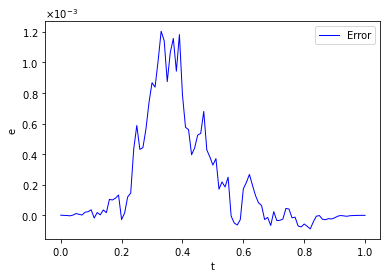

In [91]:
plt.gca().ticklabel_format(style='scientific', scilimits=(-1,0), useMathText=True)
plt.plot(ix, distance, ls = "-", lw = 1, color = "blue", label = "Error")
plt.xlabel('t')
plt.ylabel('e')
plt.legend()
plt.savefig('error.jpg',dpi = 500)
plt.show()

In [100]:
# Convert a scalar function to a vector function
def vecfunc_2_1(f):
    return np.frompyfunc(f,2,1)

In [101]:
@vecfunc_2_1
def bis(x: float, mx: np.array) -> int:
    return max(1,bisect.bisect_left(mx,x))
    

In [153]:
cdf(np.array([0.5,0.7,0.5,0.7]))

Start timing...
End timing.
Processed in 0.022952 seconds.


array([0.49927005885909626, 0.6994746607656898, 0.49927005885909626,
       0.6994746607656898], dtype=object)